In [24]:
import os
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

from ipfml.processing import transform, segmentation, compression
from ipfml import utils

from numpy.linalg import svd

In [2]:
# kitchen scene
scene_name = "p3d_kitchen"
scene_to_study = "/home/jbuisine/Documents/Thesis/Development/thesis-data/SIN3D_HD_all_center/p3d_kitchen-view0_part6"
thresholds_scene = [1980,2760,1900,1935,1825,1850,2290,1330,1265,2310,2380,1975,1405,2335,2005,2700]
mean_thresholds = int(np.mean(thresholds_scene) / 20) * 20 + 20
images_indices = np.arange(20, 10020, 20)

In [3]:
# living-room
scene_name = "p3d_living-room"
scene_to_study = "/home/jbuisine/Documents/Thesis/Development/thesis-data/SIN3D_dataset/p3d_living-room-view0_part6"
thresholds_scene = [5197,4682,4825,4254,4197,4511,4711,3597,4911,4625,5025,4797,4482,4825,4425,4340]
mean_thresholds = int(np.mean(thresholds_scene) / 20) * 20 + 20
images_indices = np.arange(20, 10020, 20)

In [25]:
# living-room-3
scene_name = "p3d_living-room-3"
scene_to_study = "/home/jbuisine/Documents/Thesis/Development/thesis-data/SIN3D_dataset/p3d_living-room-3-view0_part6"
thresholds_scene = [8680,5286,6553,2293,7153,7086,6420,2626,4420,6580,4560,7820,7086,8286,6286,6693]
mean_thresholds = int(np.mean(thresholds_scene) / 20) * 20 + 20
images_indices = np.arange(20, 10020, 20)

In [5]:
# indirect
scene_name = "p3d_indirect"
scene_to_study = "/home/jbuisine/Documents/Thesis/Development/thesis-data/SIN3D_dataset/p3d_indirect-view0_part6"
thresholds_scene = [2466,933,1533,2800,920,980,866,2200,653,920,1533,1666,980,1133,866,1060]
mean_thresholds = int(np.mean(thresholds_scene) / 20) * 20 + 20
images_indices = np.arange(20, 10020, 20)

In [6]:
# bathroom
scene_name = "p3d_bathroom"
scene_to_study = "/home/jbuisine/Documents/Thesis/Development/thesis-data/SIN3D_dataset/p3d_bathroom-view0_part6"
thresholds_scene = [2466,933,1533,2800,920,980,866,2200,653,920,1533,1666,980,1133,866,1060]
mean_thresholds = int(np.mean(thresholds_scene) / 20) * 20 + 20
images_indices = np.arange(20, 10020, 20)

In [26]:
images = sorted(os.listdir(scene_to_study))
images_path = [ os.path.join(scene_to_study, i) for i in images ]

In [27]:
pil_images = [Image.open(i) for i in images_path]

### Display SVD convergence into Kitchen scene

In [28]:
SVs_all = []
SVs_start = []
SVs_end = []
indices_to_display = [100, 500, 1500, 3000, 3500, 5000, 6500, 8000, 10000]
indices_to_display.append(mean_thresholds)
indices_to_display = sorted(indices_to_display)
for index, img in enumerate(pil_images):
    
    if images_indices[index] in indices_to_display:
        
        # then compute SVD and add it into SVDs array
        sv = transform.get_LAB_L_SVD_s(np.array(img))
        
        # only keep first interval of SV
        SVs_all.append(sv)
        SVs_start.append(sv[0:200])
        SVs_end.append(sv[200:800])

#### Display SVs

In [29]:
def display_and_save(name, sv_data, normalized):
    # display all data using matplotlib (configure plt)
    fig, ax = plt.subplots(figsize=(40, 15))
    #p_ylim = 0, 0.001

    ax.set_facecolor('#FFFFFF')
    #fig.patch.set_facecolor('#F9F9F9')

    ax.tick_params(labelsize=26)
    #plt.rc('xtick', labelsize=22)
    #plt.rc('ytick', labelsize=22)

    #plt.title(p_scene + ' scene interval information SVD['+ str(begin_data) +', '+ str(end_data) +'], from scenes indices [' + str(begin_index) + ', '+ str(end_index) + '], ' + p_feature + ' feature, ' + p_mode + ', with step of ' + str(p_step) + ', svd norm ' + str(p_norm), fontsize=24)
    ax.set_ylabel('Valeur de la composante', fontsize=44)
    ax.set_xlabel('Indices des composantes des valeurs singulières ', fontsize=44)

    for id, data in enumerate(sv_data):

        if normalized:
            data = utils.normalize_arr(data)
        #p_label = p_scene + "_" + images_indices[id]
        p_label = str(indices_to_display[id]) + " échantillons"

        if int(indices_to_display[id]) == int(mean_thresholds):
            ax.plot(data, label=p_label + " (seuil humain moyen)", lw=8, color='red')
        else:
            ax.plot(data, label=p_label, lw=4)

    plt.legend(loc=1, borderaxespad=0.2, fontsize=36)
    plt.xticks(fontsize=34)
    plt.yticks(fontsize=34)

    start_ylim, end_ylim = (0, 0.001)
    ax.set_ylim(start_ylim, end_ylim)

    #plot_name = scene_name + '_' + p_feature + '_' + str(p_step) + '_' + p_mode + '_' + str(p_norm) + '.png'
    #plt.title('{0} of SV at different samples of {1} scene'.format(name, scene_name), fontsize=40)
    plt.savefig("tmp_images/{0}_{1}_norm_{2}_start.png".format(scene_name, name, int(normalized)) , transparent=False)
    plt.plot()

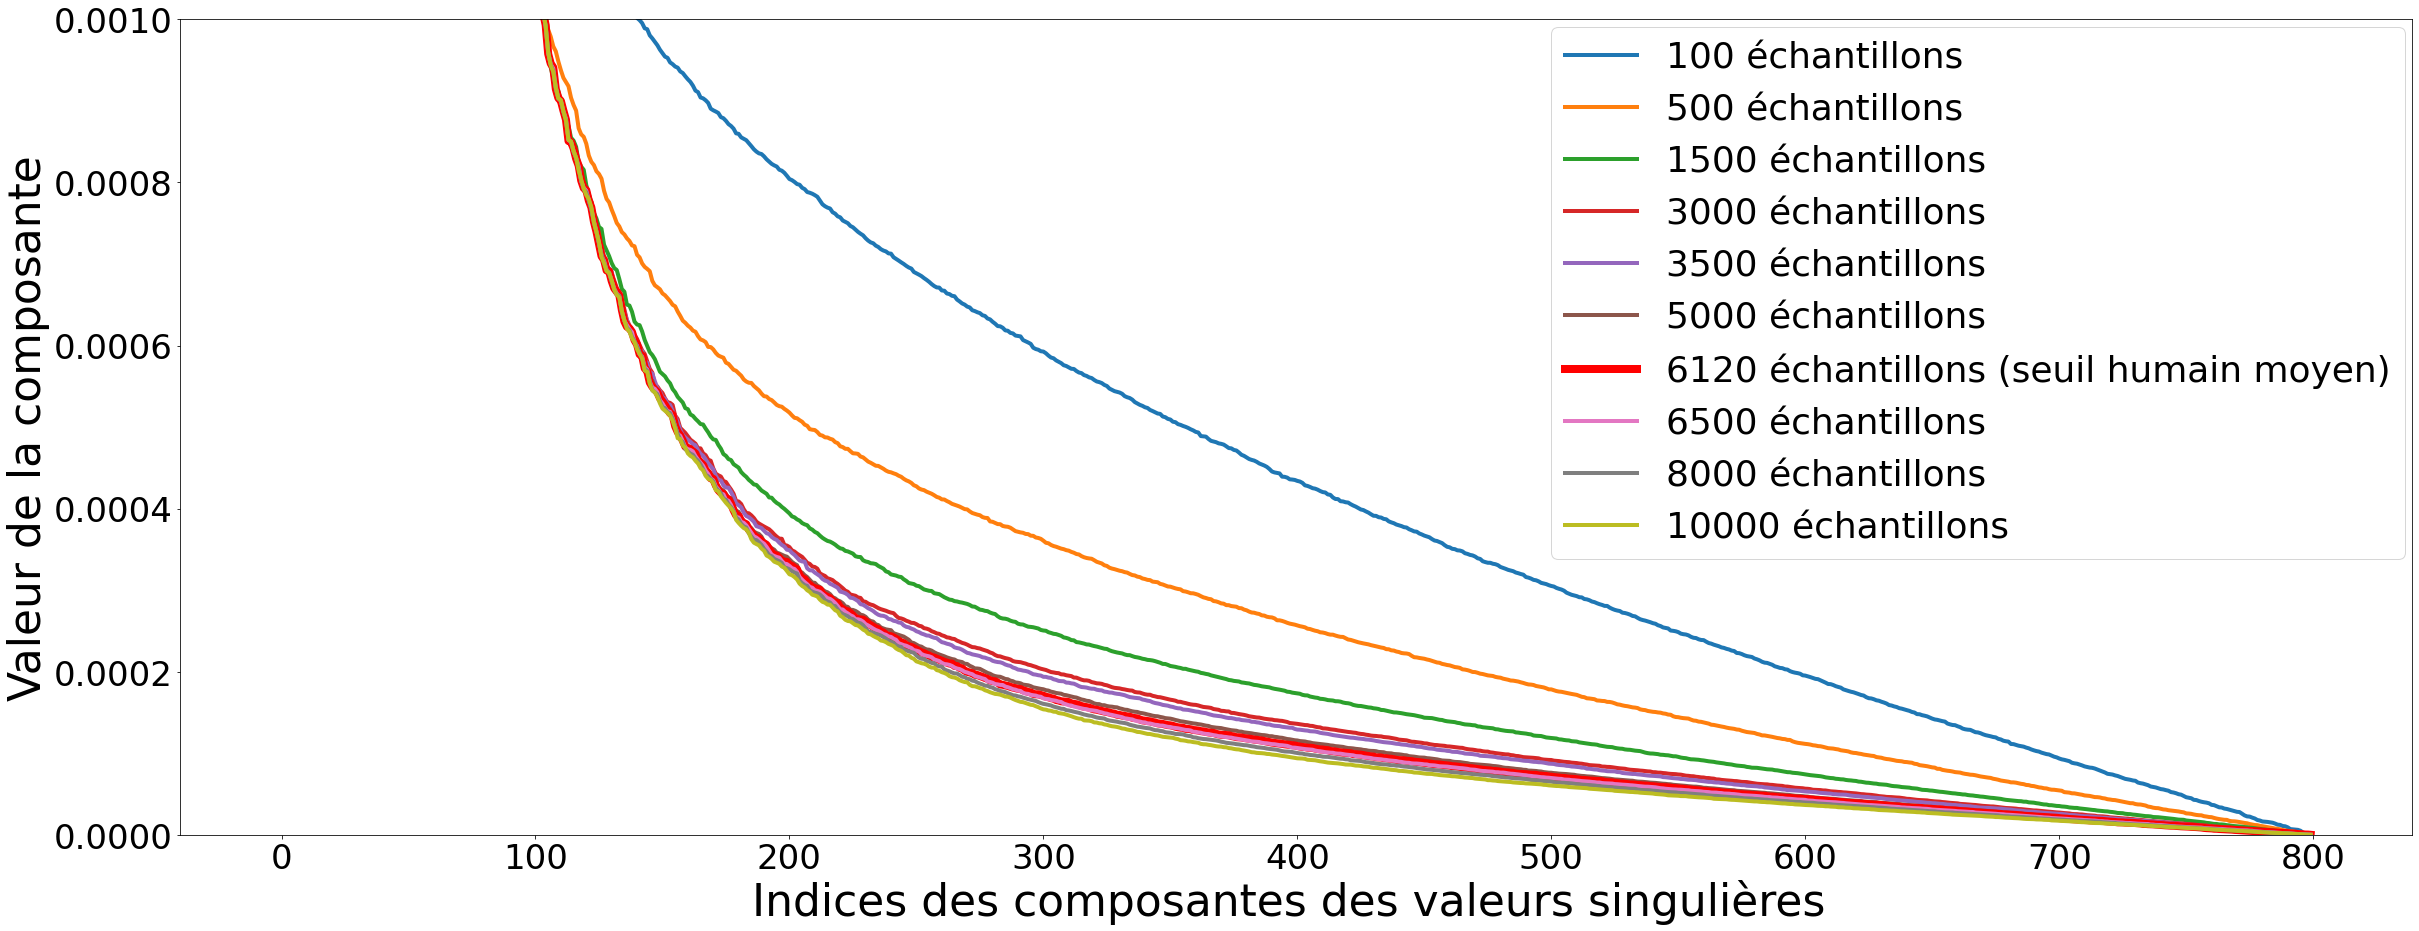

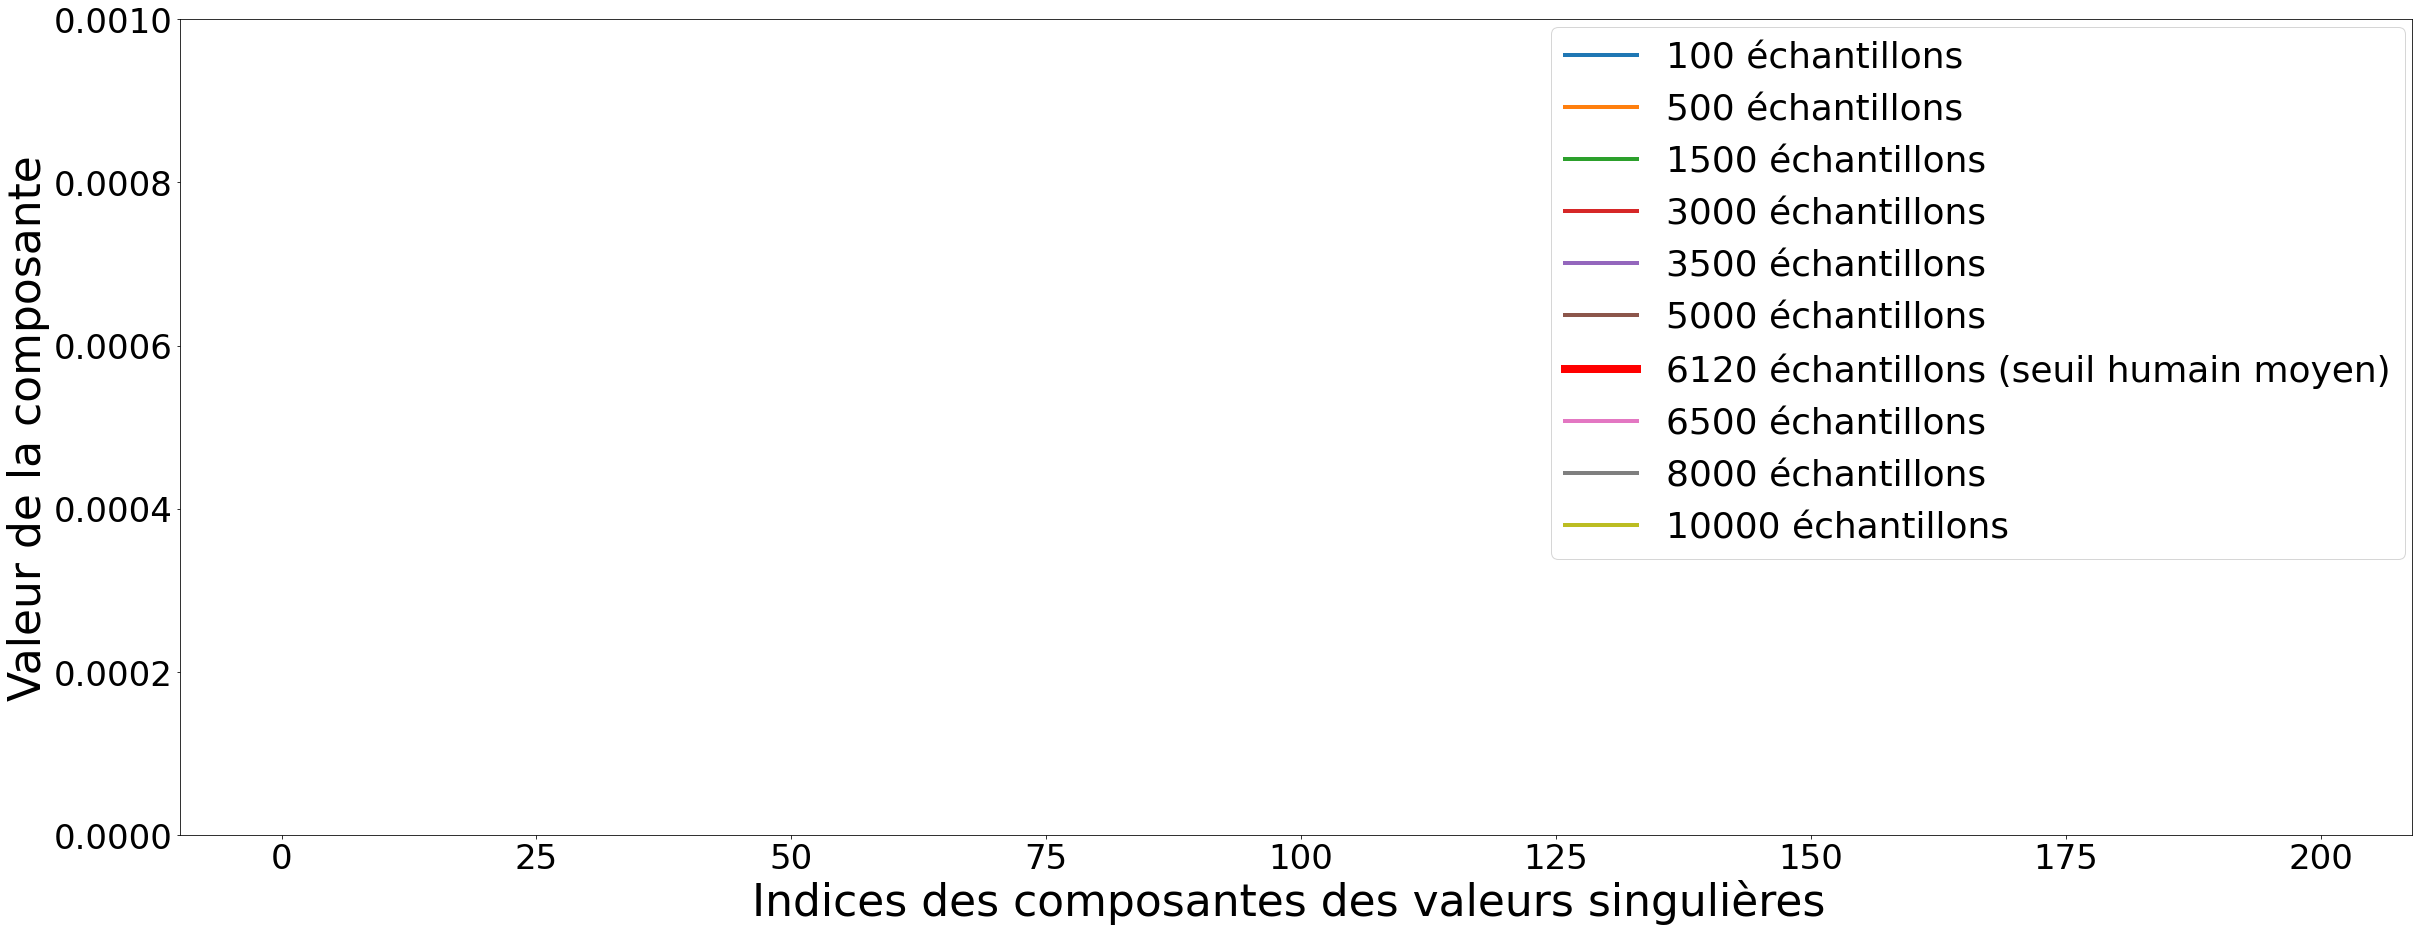

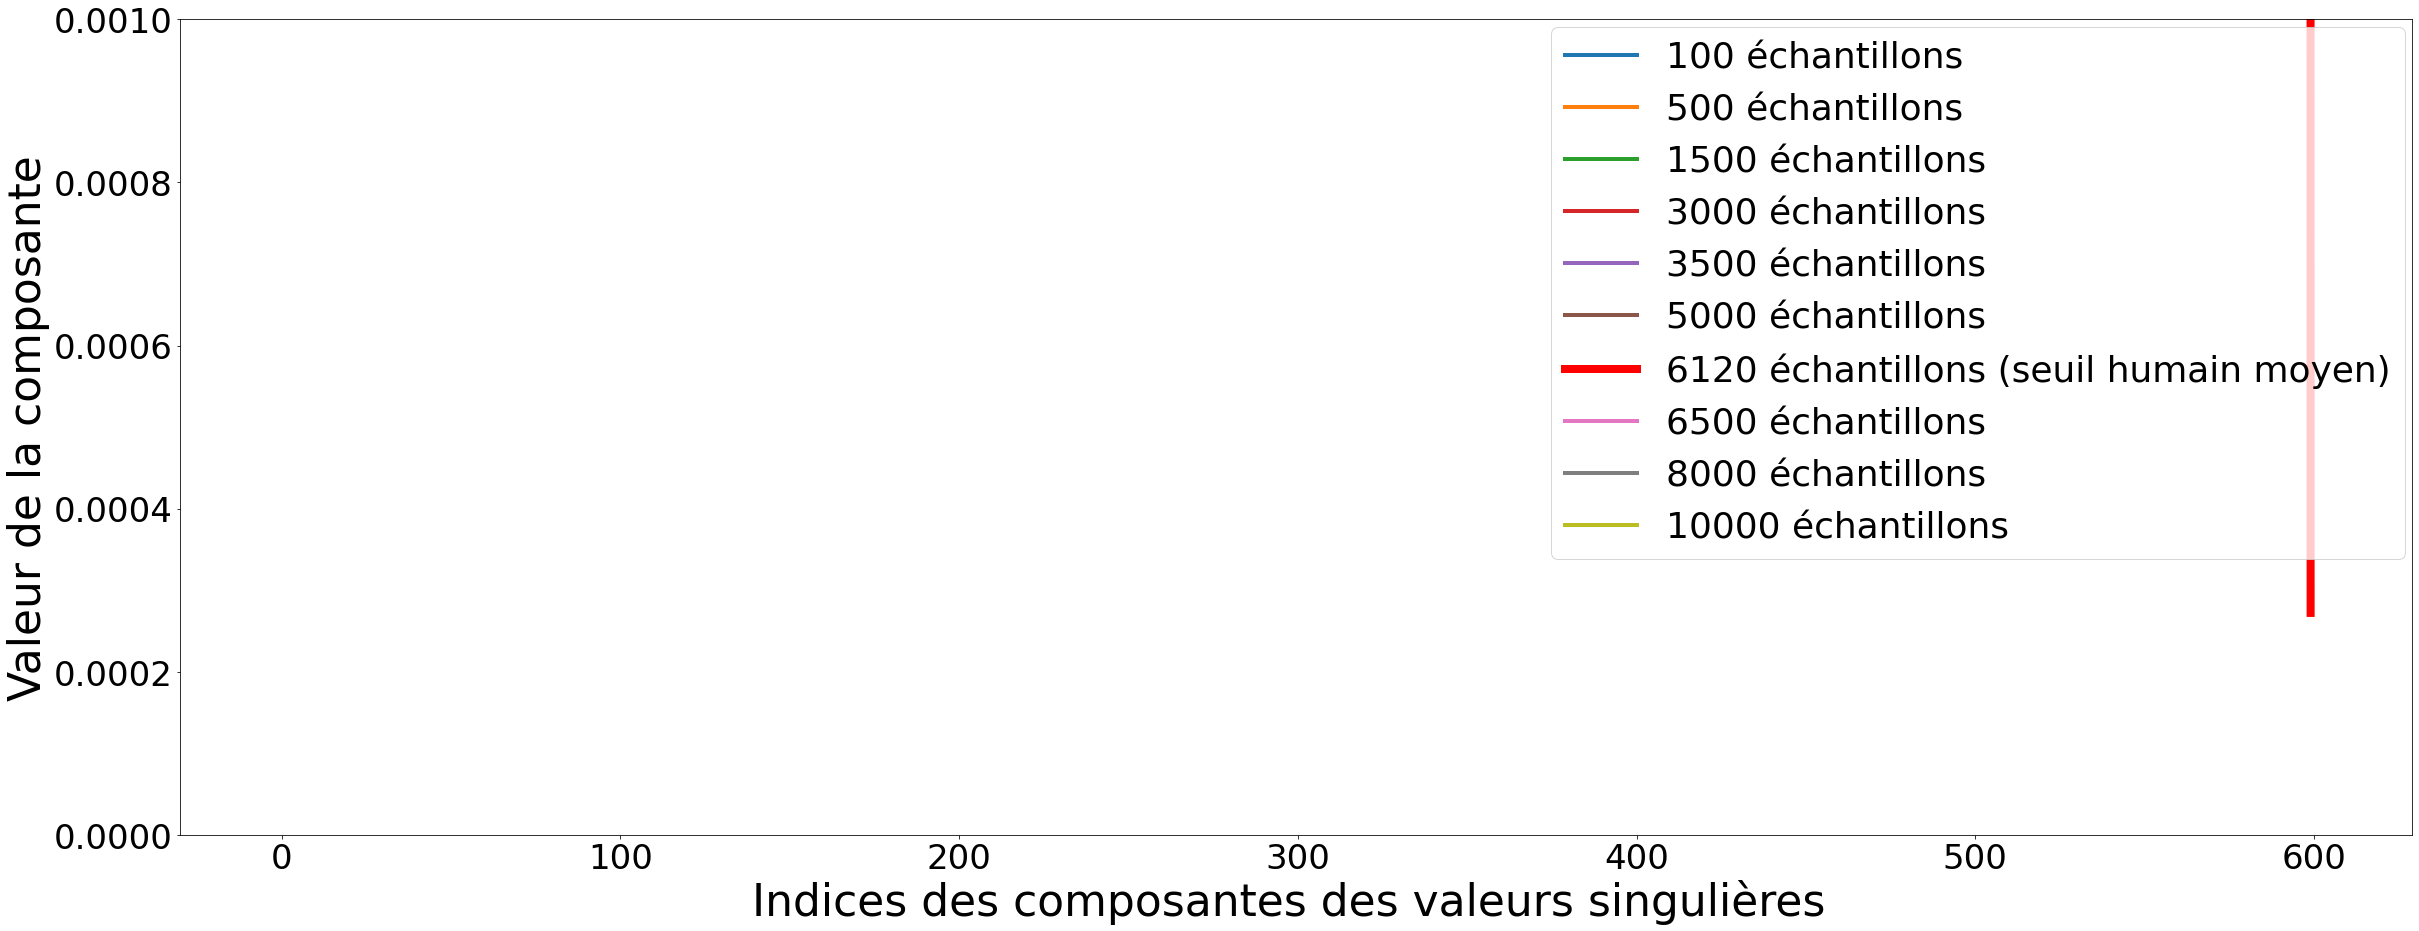

In [30]:
display_and_save("all", SVs_all, True)
display_and_save("start", SVs_start, False)
display_and_save("end", SVs_end, False)

### Zone reconstruction (structure components vs noise components)

In [31]:
def reconstruct_zone(interval, zone):
    
    output_images = []
    begin, end = interval
    lab_img = transform.get_LAB_L(zone)
    lab_img = np.array(lab_img, 'uint8')

    U, s, V = svd(lab_img)

    smat = np.zeros((end-begin, end-begin))
    smat[:, :] = np.diag(s[begin:end])
    output_img = np.dot(U[:, begin:end],  np.dot(smat, V[begin:end, :]))

    output_img = np.array(output_img, 'uint8')
        
    return output_img

In [32]:
most_noisy_image = pil_images[24]
print(images[24])
blocks = segmentation.divide_in_blocks(most_noisy_image, (200, 200))
selected_block = blocks[10]

p3d_living-room-3-view0_00500.png


In [33]:
l_selected_block = transform.get_LAB_L(selected_block)
Image.fromarray(np.array(l_selected_block, 'uint8')).save('tmp_images/original_0_200_' + scene_name +'.png')

In [34]:
structural_zone = reconstruct_zone((0, 50), selected_block)
Image.fromarray(structural_zone).save('tmp_images/reconstructed_0_50_' + scene_name +'.png')

In [35]:
noisy_zone = reconstruct_zone((50, 200), selected_block)
Image.fromarray(noisy_zone).save('tmp_images/noisy_50_200_' + scene_name + '.png')

### SVD entropy other scene

In [36]:
entropies = []
for index, img in enumerate(pil_images):
    
        
    # then compute SVD and add it into SVDs array
    sv = transform.get_LAB_L_SVD_s(np.array(img))
    svd_entropy = utils.get_entropy(sv)
    print("Extraction for {}".format(images_indices[index]))
    entropies.append(svd_entropy)

Extraction for 20
Extraction for 40
Extraction for 60
Extraction for 80
Extraction for 100
Extraction for 120
Extraction for 140
Extraction for 160
Extraction for 180
Extraction for 200
Extraction for 220
Extraction for 240
Extraction for 260
Extraction for 280
Extraction for 300
Extraction for 320
Extraction for 340
Extraction for 360
Extraction for 380
Extraction for 400
Extraction for 420
Extraction for 440
Extraction for 460
Extraction for 480
Extraction for 500
Extraction for 520
Extraction for 540
Extraction for 560
Extraction for 580
Extraction for 600
Extraction for 620
Extraction for 640
Extraction for 660
Extraction for 680
Extraction for 700
Extraction for 720
Extraction for 740
Extraction for 760
Extraction for 780
Extraction for 800
Extraction for 820
Extraction for 840
Extraction for 860
Extraction for 880
Extraction for 900
Extraction for 920
Extraction for 940
Extraction for 960
Extraction for 980
Extraction for 1000
Extraction for 1020
Extraction for 1040
Extraction fo

In [37]:
def display_sv_entropy_and_save(name, h_svd_data):
    # display all data using matplotlib (configure plt)
    fig, ax = plt.subplots(figsize=(25, 20))
    p_ylim = 0, 0.001

    ax.set_facecolor('#FFFFFF')
    #fig.patch.set_facecolor('#F9F9F9')

    ax.tick_params(labelsize=34)
    ax.set_xticks(np.arange(0, 600, step=100))
    #print([ 20 * i + 20 for i in list(range(500)) ])
    ax.set_xticklabels([0, 2000, 4000, 6000, 8000, 10000])
    #plt.rc('xtick', labelsize=22)
    #plt.rc('ytick', labelsize=22)

    #plt.title(p_scene + ' scene interval information SVD['+ str(begin_data) +', '+ str(end_data) +'], from scenes indices [' + str(begin_index) + ', '+ str(end_index) + '], ' + p_feature + ' feature, ' + p_mode + ', with step of ' + str(p_step) + ', svd norm ' + str(p_norm), fontsize=24)
    ax.set_ylabel('SVD-Entropy', fontsize=40)
    ax.set_xlabel('Nombre d\'échantillons', fontsize=40)

    threshold_id = list(images_indices).index(mean_thresholds)

    ax.plot(h_svd_data, label='SVD-Entropy', lw=6)
    ax.plot([threshold_id, threshold_id], [np.min(entropies), np.max(entropies)], 'k-', lw=10, color='red', label='Seuil humain')

    plt.legend(loc=1, borderaxespad=0.2, fontsize=40)

    start_ylim, end_ylim = p_ylim
    #ax.set_ylim(start_ylim, end_ylim)

    #plot_name = scene_name + '_' + p_feature + '_' + str(p_step) + '_' + p_mode + '_' + str(p_norm) + '.png'
    #plt.title('SVD-Entropy at different samples of ' + scene_name + ' scene', fontsize=40)
    plt.savefig("tmp_images/svd_entropy_{0}.png".format(scene_name) , transparent=True)
    plt.plot()

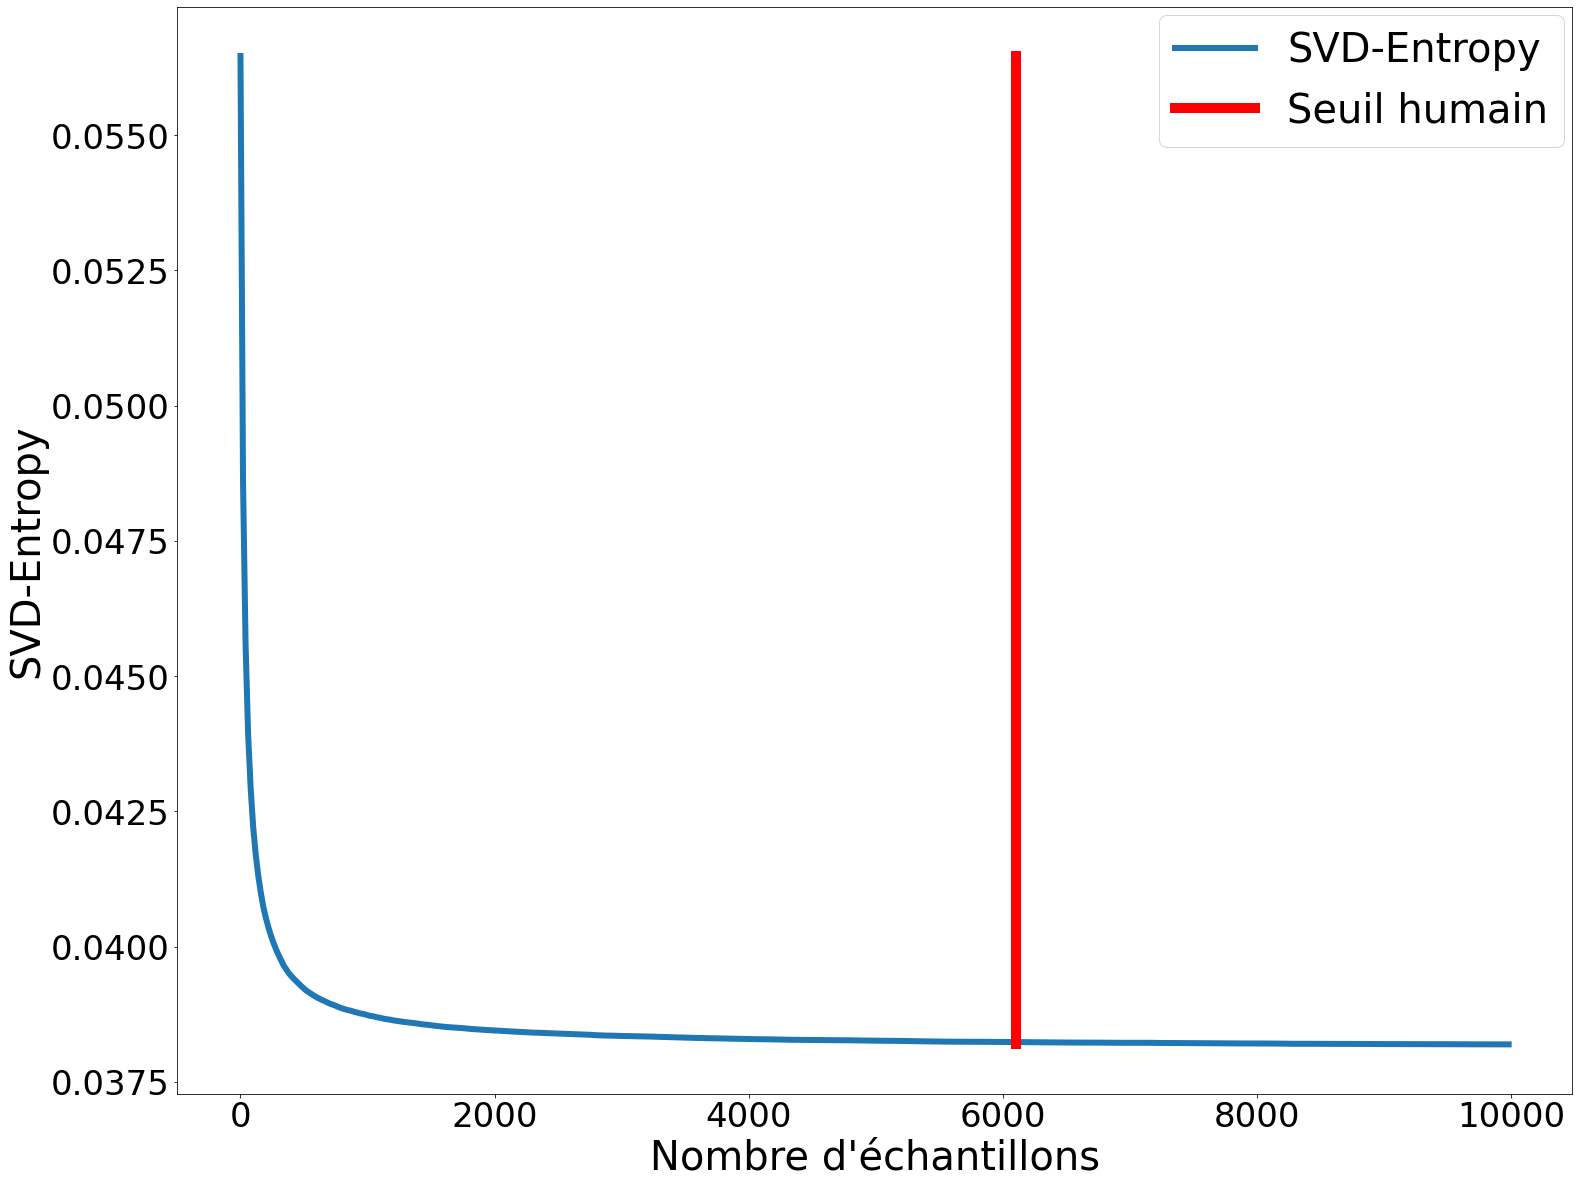

In [38]:
display_sv_entropy_and_save(scene_name, entropies)

### SVD-Entropy for each zone

In [52]:
zones_entropies = {}

n_zones = 16
zones_indices = np.arange(n_zones)
zones_names = [ "bloc " + str(i + 1) for i in zones_indices ]

for i in zones_indices:
    zones_entropies[i] = []

for index, img in enumerate(pil_images):
    
        
    # then compute SVD and add it into SVDs array
    l_img = transform.get_LAB_L(np.array(img))
    
    blocks = segmentation.divide_in_blocks(l_img, (200, 200))
    
    for b_index, b in enumerate(blocks):
        
        sv = compression.get_SVD_s(b)
        svd_entropy = utils.get_entropy(sv[50:200])
        zones_entropies[b_index].append(svd_entropy)
    print("Extraction for {}".format(images_indices[index]))
    

Extraction for 20
Extraction for 40
Extraction for 60
Extraction for 80
Extraction for 100
Extraction for 120
Extraction for 140
Extraction for 160
Extraction for 180
Extraction for 200
Extraction for 220
Extraction for 240
Extraction for 260
Extraction for 280
Extraction for 300
Extraction for 320
Extraction for 340
Extraction for 360
Extraction for 380
Extraction for 400
Extraction for 420
Extraction for 440
Extraction for 460
Extraction for 480
Extraction for 500
Extraction for 520
Extraction for 540
Extraction for 560
Extraction for 580
Extraction for 600
Extraction for 620
Extraction for 640
Extraction for 660
Extraction for 680
Extraction for 700
Extraction for 720
Extraction for 740
Extraction for 760
Extraction for 780
Extraction for 800
Extraction for 820
Extraction for 840
Extraction for 860
Extraction for 880
Extraction for 900
Extraction for 920
Extraction for 940
Extraction for 960
Extraction for 980
Extraction for 1000
Extraction for 1020
Extraction for 1040
Extraction fo

In [40]:
selected_blocks = [0, 7, 10, 12]

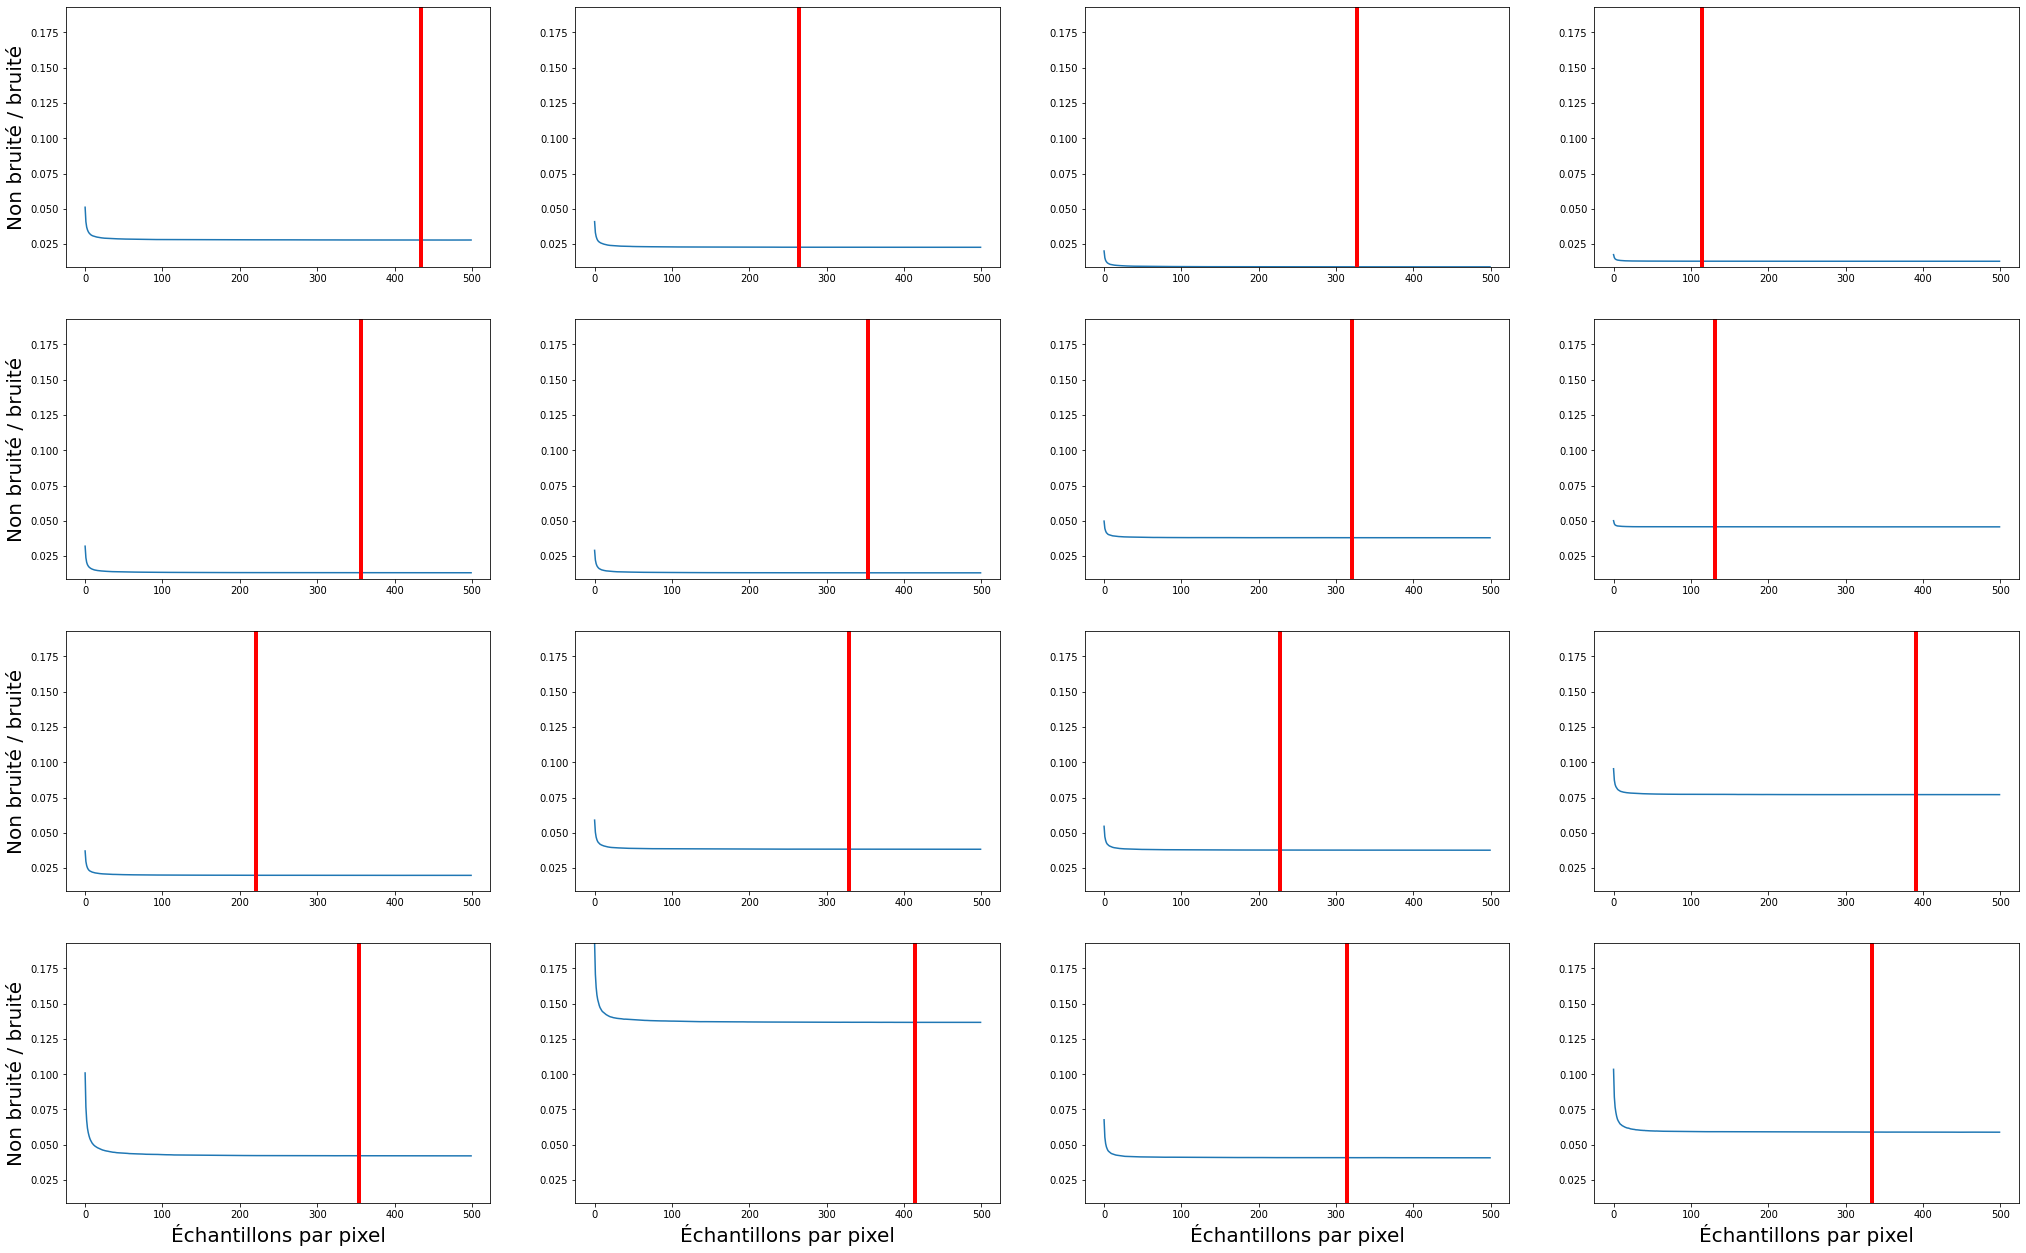

In [41]:
fig=plt.figure(figsize=(35, 22))
#fig.suptitle("Detection simulation for Kitchen scene", fontsize=20)

step_value = 20
label_freq = 50
max_value = 0
min_value = 100000

for index, row in zones_entropies.items():
    if np.max(row) > max_value:
        max_value = np.max(row)
    if np.min(row) < min_value:
        min_value = np.min(row)

for index, row in zones_entropies.items():

    row = np.asarray(row)

    fig.add_subplot(4, 4, (index + 1))
    plt.plot(row)
    
    threshold_value = thresholds_scene[index] - (thresholds_scene[index] % step_value) + step_value
    threshold_id = list(images_indices).index(threshold_value)
    
    # draw vertical line from (70,100) to (70, 250)
    plt.plot([threshold_id, threshold_id], [min_value, max_value], 'k-', lw=4, color='red')

    if index % 4 == 0:
        plt.ylabel('Non bruité / bruité', fontsize=20)

    if index >= 12:
        plt.xlabel('Échantillons par pixel', fontsize=20)

    #x_labels = [id * step_value + start_index for id, val in enumerate(row[5:]) if id % label_freq == 0]

    #x = [v for v in np.arange(0, len(row[5:])+1) if v % label_freq == 0]

    #plt.xticks(x, x_labels, rotation=45)
    plt.ylim(min_value, max_value)


0.002002176391876788
0.00199701827949661
0.002004051524268217
0.0019987549683967965


[]

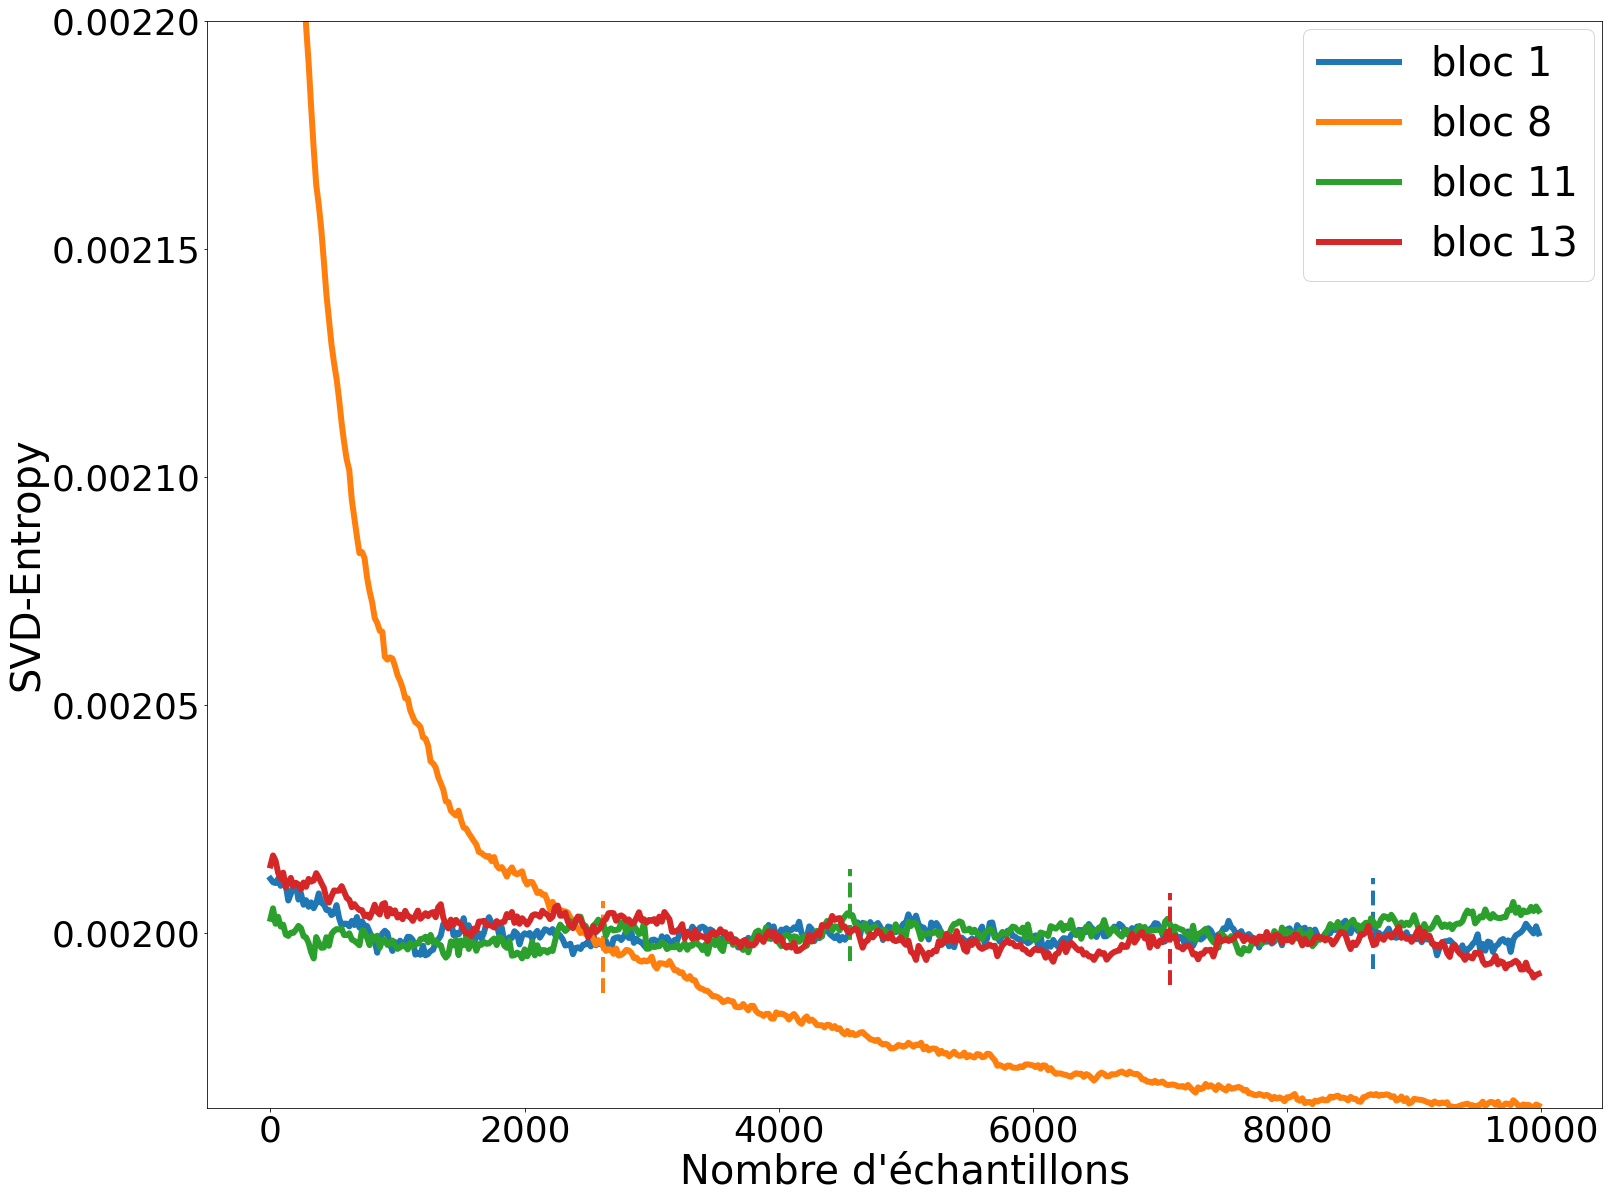

In [55]:
step_value = 20
label_freq = 50
max_value = 0
min_value = 100000

fig, ax = plt.subplots(figsize=(25, 20))
zones_names = [ "bloc " + str(i + 1) for i in zones_indices ]
#p_ylim = 0, 0.001

colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
ax.set_facecolor('#FFFFFF')
#fig.patch.set_facecolor('#F9F9F9')

ax.tick_params(labelsize=34)
ax.set_xticks(np.arange(0, 600, step=100))
#print([ 20 * i + 20 for i in list(range(500)) ])
ax.set_xticklabels([0, 2000, 4000, 6000, 8000, 10000])

ax.set_ylabel('SVD-Entropy', fontsize=40)
ax.set_xlabel('Nombre d\'échantillons', fontsize=40)

for index, row in zones_entropies.items():
    
    if index in selected_blocks:
        row = np.array(row) 
        row = utils.normalize_arr(row)
        
        block_index = selected_blocks.index(index)
 
        plt.plot(row, label=zones_names[index], color=colors[block_index], lw=6)
        
        if np.max(row) > max_value:
            max_value = np.max(row)
        if np.min(row) < min_value:
            min_value = np.min(row)
            
        threshold_id = int(thresholds_scene[index] / 20)
        value = row[threshold_id]
        print(value)
        #plt.plot([threshold_id, threshold_id], [value - 0.003, value + 0.003], linestyle='--', lw=4, color=colors[block_index])
        plt.plot([threshold_id, threshold_id], [value - 0.00001, value + 0.00001], linestyle='--', lw=4, color=colors[block_index])

# draw vertical line from (70,100) to (70, 250)

#x_labels = [id * step_value + start_index for id, val in enumerate(row[5:]) if id % label_freq == 0]

#x = [v for v in np.arange(0, len(row[5:])+1) if v % label_freq == 0]

plt.legend(loc=0, borderaxespad=0.2, fontsize=40)
plt.xticks(fontsize=36)
plt.yticks(fontsize=36)

#plt.xticks(x, x_labels, rotation=45)
plt.ylim(min_value, 0.0022)

plt.savefig("tmp_images/"+scene_name+"_svd_entropy_blocks_50_200_norm.png" , transparent=True)
plt.plot()


### Model comparisons and k param selection

In [ ]:
# SVD-Entropy
auc_roc = [0.8043433828573073, 0.8071165701153609, 0.8194730902821024, 0.8213497848505238, 0.8242025085876494, 0.825521923277946, 0.820978664075863, 0.8216199771758744]
label_title = "RNN avec les attributs SVD-Entropy"
output_image_name = "tmp_images/k_param_curve_svd-entropy.png"
index_auc = 5

In [ ]:
# 26 attributes
auc_roc = [0.7603368498078632, 0.77133024818651, 0.7571939745269107, 0.7726889379182741, 0.781090691630369, 0.8077689016577472, 0.8060296815813653, 0.8041339656442563]
label_title = "RNN avec les attributs de Constantin (2015)"
output_image_name = "tmp_images/k_param_curve_26-attributes.png"
index_auc = 5

In [ ]:
fig, ax = plt.subplots(figsize=(30, 20))

ax.set_facecolor('#FFFFFF')
#fig.patch.set_facecolor('#F9F9F9')

ax.tick_params(labelsize=34)
ax.set_xticks(range(len(auc_roc)))
#print([ 20 * i + 20 for i in list(range(500)) ])
ax.set_xticklabels(range(3, 11))

#means = auc_roc
#confidences = (1.9 * np.std(auc_roc)) / np.sqrt(len(auc_roc))

from scipy.interpolate import make_interp_spline, BSpline

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(3, 11, 300) 

spl = make_interp_spline(range(3,11), auc_roc, k=3)  # type: BSpline
power_smooth = spl(xnew)

        
ax.set_ylabel('Score test AUC ROC', fontsize=40)
ax.set_xlabel('k', fontsize=40)

plt.plot(auc_roc, label=label_title, lw=6)
plt.plot([0, 8], [auc_roc[index_auc], auc_roc[index_auc]], label="Compromis", lw=6, color='red', linestyle="--")
#plt.plot(xnew, power_smooth, label=zones_names[index], lw=6)
#plt.fill_between(range(len(auc_roc)), means-confidences, means+confidences, alpha=.25)

plt.legend(loc=2, borderaxespad=0.2, fontsize=40)

#plt.xticks(x, x_labels, rotation=45)
plt.ylim(np.min(auc_roc), 0.83)

plt.savefig(output_image_name , transparent=True)
plt.plot()